Setting up requirements

In [1]:
%matplotlib inline

In [2]:
!pip install pydub torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 844.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 94.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0+cu121
    Uninstalling torchvision-0.19.0+cu121:
      Successfully uninstalled torchvision-0.19.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.0+cu121
    Uninstalling torchaudio-2.4.0+cu121:
      Successfully uninstalled torchaudio-2.4.0+cu121


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Loading dataset

In [4]:
!pip install rarfile

In [5]:
import rarfile
import os

def extract_rar(rar_path, extract_to):
    # Ensure the extract directory exists
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # Open and extract the .rar file
    with rarfile.RarFile(rar_path) as rf:
        rf.extractall(path=extract_to)

    print(f"Extracted to {extract_to}")

# Path to your .rar file and where to extract
rar_file_path = "/content/recordings_v2.rar"
extract_to_path = "/content"

# Extract the .rar file
extract_rar(rar_file_path, extract_to_path)


Extracted to /content


In [7]:
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import os
from torchaudio.transforms import Resample

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, dataset_path: str = "./", target_sample_rate: int = 16000):
        super().__init__(dataset_path, download=False)
        self.target_sample_rate = target_sample_rate

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

    def __getitem__(self, n):
        # Load the waveform, sample rate, and metadata
        fileid = self._walker[n]
        waveform, sample_rate = torchaudio.load(fileid)

        # Resample if necessary
        if sample_rate != self.target_sample_rate:
            resampler = Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)

        label = os.path.basename(os.path.dirname(fileid))
        speaker_id = fileid.split("/")[-2]  # Extract speaker ID from path
        utterance_number = int(os.path.basename(fileid).split("_")[-1].split(".")[0])

        return waveform, self.target_sample_rate, label, speaker_id, utterance_number

# Specify the path to your local dataset folder and target sample rate
local_dataset_path = "/content/recordings_v2"
target_sample_rate = 16000

# Create training and testing split using the local folder and resampling
train_set = SubsetSC("training", dataset_path=local_dataset_path, target_sample_rate=target_sample_rate)
test_set = SubsetSC("testing", dataset_path=local_dataset_path, target_sample_rate=target_sample_rate)

# Example usage: access the first sample
waveform, sample_rate, label, speaker_id, utterance_number = train_set[-1]


Showing waveform

Shape of waveform: torch.Size([2, 17280])
Sample rate of waveform: 16000
Label of waveform: zero


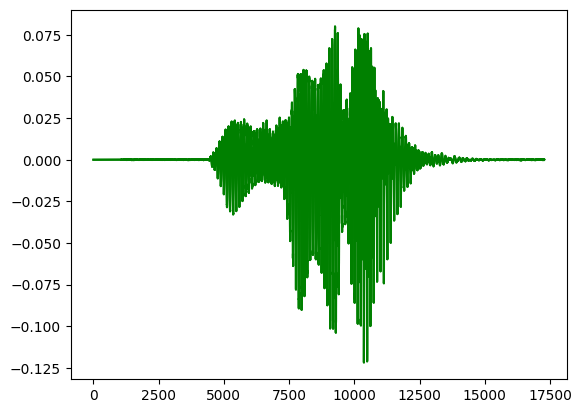

In [15]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("Label of waveform: {}".format(label))

plt.plot(waveform.t().numpy(), color='green');

Showing labels in the dataset

In [16]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

Checking Audios

In [17]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [18]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is me saying “zero”.







In [19]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting Dataset

In [20]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [21]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [22]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 10

if device == "cuda":
    num_workers = 256
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Defining network

In [23]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(2, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network




In [25]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data.contiguous()) # Ensure data is contiguous before applying transform
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [26]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data.contiguous())
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.03409090909090909/20 [00:01<13:58, 42.01s/it]  

Train Epoch: 1 [0/700 (0%)]	Loss: 3.636353


  1%|          | 0.10227272727272729/20 [00:02<03:57, 11.94s/it]

Train Epoch: 1 [50/700 (7%)]	Loss: 3.948618


  1%|          | 0.14772727272727273/20 [00:02<02:43,  8.22s/it]

Train Epoch: 1 [100/700 (14%)]	Loss: 3.835051


  1%|          | 0.21590909090909086/20 [00:02<02:09,  6.57s/it]

Train Epoch: 1 [150/700 (21%)]	Loss: 3.420771


  1%|▏         | 0.2613636363636363/20 [00:03<01:59,  6.07s/it] 

Train Epoch: 1 [200/700 (29%)]	Loss: 3.542854


  2%|▏         | 0.3295454545454544/20 [00:03<01:59,  6.06s/it]

Train Epoch: 1 [250/700 (36%)]	Loss: 3.452695


  2%|▏         | 0.3863636363636362/20 [00:03<01:36,  4.94s/it]

Train Epoch: 1 [300/700 (43%)]	Loss: 3.231825


  2%|▏         | 0.4545454545454543/20 [00:03<01:24,  4.35s/it] 

Train Epoch: 1 [350/700 (50%)]	Loss: 3.479634


  2%|▏         | 0.48863636363636337/20 [00:04<01:25,  4.36s/it]

Train Epoch: 1 [400/700 (57%)]	Loss: 3.028683


  3%|▎         | 0.5568181818181815/20 [00:04<01:18,  4.04s/it]

Train Epoch: 1 [450/700 (64%)]	Loss: 2.989085


  3%|▎         | 0.6249999999999997/20 [00:04<01:14,  3.84s/it]

Train Epoch: 1 [500/700 (71%)]	Loss: 3.292614


  3%|▎         | 0.6590909090909087/20 [00:04<01:14,  3.84s/it]

Train Epoch: 1 [550/700 (79%)]	Loss: 2.910281


  4%|▎         | 0.7272727272727268/20 [00:05<01:17,  4.02s/it]

Train Epoch: 1 [600/700 (86%)]	Loss: 2.668395


  4%|▍         | 0.795454545454545/20 [00:05<01:13,  3.85s/it] 

Train Epoch: 1 [650/700 (93%)]	Loss: 3.073520


  5%|▌         | 1.0454545454545452/20 [00:06<01:07,  3.57s/it]


Test Epoch: 1	Accuracy: 50/175 (29%)

Train Epoch: 2 [0/700 (0%)]	Loss: 2.649062


  6%|▌         | 1.113636363636364/20 [00:06<01:10,  3.72s/it] 

Train Epoch: 2 [50/700 (7%)]	Loss: 2.507453


  6%|▌         | 1.1477272727272734/20 [00:06<01:11,  3.82s/it]

Train Epoch: 2 [100/700 (14%)]	Loss: 2.458139


  6%|▌         | 1.2159090909090922/20 [00:06<01:13,  3.92s/it]

Train Epoch: 2 [150/700 (21%)]	Loss: 3.010656


  6%|▋         | 1.2500000000000016/20 [00:06<01:14,  3.99s/it]

Train Epoch: 2 [200/700 (29%)]	Loss: 2.735178


  7%|▋         | 1.3181818181818203/20 [00:07<01:17,  4.16s/it]

Train Epoch: 2 [250/700 (36%)]	Loss: 2.135712


  7%|▋         | 1.3863636363636391/20 [00:07<01:13,  3.92s/it]

Train Epoch: 2 [300/700 (43%)]	Loss: 1.933530


  7%|▋         | 1.454545454545458/20 [00:07<01:15,  4.09s/it] 

Train Epoch: 2 [350/700 (50%)]	Loss: 2.459278


  7%|▋         | 1.4886363636363673/20 [00:07<01:15,  4.09s/it]

Train Epoch: 2 [400/700 (57%)]	Loss: 1.986760


  8%|▊         | 1.556818181818186/20 [00:08<01:16,  4.17s/it] 

Train Epoch: 2 [450/700 (64%)]	Loss: 2.191929


  8%|▊         | 1.6250000000000049/20 [00:08<01:13,  4.02s/it]

Train Epoch: 2 [500/700 (71%)]	Loss: 1.705071


  8%|▊         | 1.6590909090909143/20 [00:08<01:12,  3.97s/it]

Train Epoch: 2 [550/700 (79%)]	Loss: 2.789283


  9%|▊         | 1.727272727272733/20 [00:08<01:11,  3.92s/it] 

Train Epoch: 2 [600/700 (86%)]	Loss: 2.146654


  9%|▉         | 1.7954545454545519/20 [00:09<01:14,  4.07s/it]

Train Epoch: 2 [650/700 (93%)]	Loss: 2.186150


 10%|█         | 2.0340909090909167/20 [00:10<01:07,  3.75s/it]


Test Epoch: 2	Accuracy: 67/175 (38%)

Train Epoch: 3 [0/700 (0%)]	Loss: 1.877223


 11%|█         | 2.102272727272734/20 [00:10<01:09,  3.90s/it] 

Train Epoch: 3 [50/700 (7%)]	Loss: 1.866479


 11%|█         | 2.1704545454545516/20 [00:10<01:08,  3.85s/it]

Train Epoch: 3 [100/700 (14%)]	Loss: 1.477410


 11%|█         | 2.2045454545454604/20 [00:10<01:09,  3.91s/it]

Train Epoch: 3 [150/700 (21%)]	Loss: 1.807789


 11%|█▏        | 2.272727272727278/20 [00:11<01:10,  3.98s/it]

Train Epoch: 3 [200/700 (29%)]	Loss: 1.648383


 12%|█▏        | 2.3409090909090953/20 [00:11<01:11,  4.05s/it]

Train Epoch: 3 [250/700 (36%)]	Loss: 1.707309


 12%|█▏        | 2.375000000000004/20 [00:11<01:10,  4.01s/it] 

Train Epoch: 3 [300/700 (43%)]	Loss: 1.663427


 12%|█▏        | 2.4431818181818215/20 [00:11<01:09,  3.95s/it]

Train Epoch: 3 [350/700 (50%)]	Loss: 1.670066


 13%|█▎        | 2.511363636363639/20 [00:11<01:08,  3.92s/it]

Train Epoch: 3 [400/700 (57%)]	Loss: 1.260178


 13%|█▎        | 2.5454545454545476/20 [00:12<01:08,  3.91s/it]

Train Epoch: 3 [450/700 (64%)]	Loss: 1.646665


 13%|█▎        | 2.613636363636365/20 [00:12<01:08,  3.93s/it] 

Train Epoch: 3 [500/700 (71%)]	Loss: 1.474913


 13%|█▎        | 2.6818181818181825/20 [00:12<01:06,  3.84s/it]

Train Epoch: 3 [550/700 (79%)]	Loss: 1.620999


 14%|█▎        | 2.7159090909090913/20 [00:12<01:06,  3.83s/it]

Train Epoch: 3 [600/700 (86%)]	Loss: 1.449931


 14%|█▍        | 2.7840909090909087/20 [00:13<01:07,  3.89s/it]

Train Epoch: 3 [650/700 (93%)]	Loss: 1.519074


 15%|█▌        | 3.02272727272727/20 [00:14<01:14,  4.38s/it] 


Test Epoch: 3	Accuracy: 92/175 (53%)

Train Epoch: 4 [0/700 (0%)]	Loss: 0.655929


 16%|█▌        | 3.1022727272727235/20 [00:14<01:25,  5.06s/it]

Train Epoch: 4 [50/700 (7%)]	Loss: 1.160990


 16%|█▌        | 3.1477272727272685/20 [00:14<01:25,  5.08s/it]

Train Epoch: 4 [100/700 (14%)]	Loss: 1.655404


 16%|█▌        | 3.215909090909086/20 [00:15<01:30,  5.40s/it] 

Train Epoch: 4 [150/700 (21%)]	Loss: 1.423458


 16%|█▋        | 3.261363636363631/20 [00:15<01:32,  5.53s/it] 

Train Epoch: 4 [200/700 (29%)]	Loss: 1.360214


 17%|█▋        | 3.3295454545454484/20 [00:15<01:34,  5.70s/it]

Train Epoch: 4 [250/700 (36%)]	Loss: 1.285073


 17%|█▋        | 3.3749999999999933/20 [00:16<01:35,  5.75s/it]

Train Epoch: 4 [300/700 (43%)]	Loss: 1.869697


 17%|█▋        | 3.4204545454545383/20 [00:16<01:37,  5.87s/it]

Train Epoch: 4 [350/700 (50%)]	Loss: 1.340011


 17%|█▋        | 3.4886363636363558/20 [00:16<01:18,  4.78s/it]

Train Epoch: 4 [400/700 (57%)]	Loss: 1.099540


 18%|█▊        | 3.556818181818173/20 [00:16<01:10,  4.32s/it] 

Train Epoch: 4 [450/700 (64%)]	Loss: 0.556315


 18%|█▊        | 3.590909090909082/20 [00:16<01:09,  4.24s/it]

Train Epoch: 4 [500/700 (71%)]	Loss: 1.311021


 18%|█▊        | 3.6590909090908994/20 [00:17<01:08,  4.20s/it]

Train Epoch: 4 [550/700 (79%)]	Loss: 0.696858


 19%|█▊        | 3.727272727272717/20 [00:17<01:06,  4.08s/it]

Train Epoch: 4 [600/700 (86%)]	Loss: 0.372720


 19%|█▉        | 3.7954545454545343/20 [00:17<01:04,  3.99s/it]

Train Epoch: 4 [650/700 (93%)]	Loss: 0.261149


 20%|██        | 4.034090909090897/20 [00:18<00:57,  3.59s/it] 


Test Epoch: 4	Accuracy: 127/175 (73%)

Train Epoch: 5 [0/700 (0%)]	Loss: 0.737121


 21%|██        | 4.102272727272717/20 [00:18<00:59,  3.74s/it]

Train Epoch: 5 [50/700 (7%)]	Loss: 1.023486


 21%|██        | 4.170454545454537/20 [00:19<01:01,  3.90s/it]

Train Epoch: 5 [100/700 (14%)]	Loss: 0.745079


 21%|██        | 4.204545454545447/20 [00:19<01:01,  3.88s/it]

Train Epoch: 5 [150/700 (21%)]	Loss: 0.323792


 21%|██▏       | 4.272727272727267/20 [00:19<01:01,  3.93s/it]

Train Epoch: 5 [200/700 (29%)]	Loss: 0.603706


 22%|██▏       | 4.340909090909087/20 [00:19<01:01,  3.94s/it]

Train Epoch: 5 [250/700 (36%)]	Loss: 0.748360


 22%|██▏       | 4.374999999999997/20 [00:19<01:01,  3.95s/it]

Train Epoch: 5 [300/700 (43%)]	Loss: 0.438946


 22%|██▏       | 4.4431818181818175/20 [00:20<01:03,  4.07s/it]

Train Epoch: 5 [350/700 (50%)]	Loss: 0.413388


 23%|██▎       | 4.511363636363638/20 [00:20<01:02,  4.06s/it] 

Train Epoch: 5 [400/700 (57%)]	Loss: 0.674181


 23%|██▎       | 4.545454545454548/20 [00:20<01:01,  3.98s/it]

Train Epoch: 5 [450/700 (64%)]	Loss: 0.835715


 23%|██▎       | 4.613636363636368/20 [00:20<00:58,  3.80s/it]

Train Epoch: 5 [500/700 (71%)]	Loss: 0.800763


 23%|██▎       | 4.681818181818188/20 [00:21<01:00,  3.95s/it]

Train Epoch: 5 [550/700 (79%)]	Loss: 0.540657


 24%|██▎       | 4.715909090909098/20 [00:21<00:59,  3.90s/it]

Train Epoch: 5 [600/700 (86%)]	Loss: 0.839064


 24%|██▍       | 4.784090909090918/20 [00:21<01:01,  4.05s/it]

Train Epoch: 5 [650/700 (93%)]	Loss: 0.509933


 25%|██▌       | 5.0227272727272885/20 [00:22<00:51,  3.44s/it]


Test Epoch: 5	Accuracy: 152/175 (87%)

Train Epoch: 6 [0/700 (0%)]	Loss: 0.411947


 25%|██▌       | 5.090909090909109/20 [00:22<00:55,  3.73s/it] 

Train Epoch: 6 [50/700 (7%)]	Loss: 0.340057


 26%|██▌       | 5.159090909090929/20 [00:23<00:56,  3.83s/it]

Train Epoch: 6 [100/700 (14%)]	Loss: 0.378429


 26%|██▌       | 5.227272727272749/20 [00:23<00:56,  3.84s/it]

Train Epoch: 6 [150/700 (21%)]	Loss: 0.658869


 26%|██▋       | 5.261363636363659/20 [00:23<00:55,  3.79s/it]

Train Epoch: 6 [200/700 (29%)]	Loss: 0.323530


 27%|██▋       | 5.329545454545479/20 [00:23<00:57,  3.90s/it]

Train Epoch: 6 [250/700 (36%)]	Loss: 0.570214


 27%|██▋       | 5.397727272727299/20 [00:23<00:56,  3.89s/it]

Train Epoch: 6 [300/700 (43%)]	Loss: 0.470798


 27%|██▋       | 5.431818181818209/20 [00:24<00:57,  3.98s/it]

Train Epoch: 6 [350/700 (50%)]	Loss: 0.873191


 28%|██▊       | 5.500000000000029/20 [00:24<00:56,  3.89s/it]

Train Epoch: 6 [400/700 (57%)]	Loss: 0.507124


 28%|██▊       | 5.568181818181849/20 [00:24<00:56,  3.91s/it]

Train Epoch: 6 [450/700 (64%)]	Loss: 0.678620


 28%|██▊       | 5.6022727272727595/20 [00:24<00:57,  3.99s/it]

Train Epoch: 6 [500/700 (71%)]	Loss: 0.178957


 28%|██▊       | 5.67045454545458/20 [00:25<00:58,  4.05s/it]  

Train Epoch: 6 [550/700 (79%)]	Loss: 0.299188


 29%|██▊       | 5.7386363636364/20 [00:25<00:56,  3.94s/it] 

Train Epoch: 6 [600/700 (86%)]	Loss: 0.268322


 29%|██▉       | 5.77272727272731/20 [00:25<00:55,  3.89s/it]

Train Epoch: 6 [650/700 (93%)]	Loss: 0.489287


 30%|███       | 6.01136363636368/20 [00:26<00:47,  3.38s/it]


Test Epoch: 6	Accuracy: 157/175 (90%)

Train Epoch: 7 [0/700 (0%)]	Loss: 0.214190


 30%|███       | 6.0795454545455/20 [00:26<01:02,  4.45s/it] 

Train Epoch: 7 [50/700 (7%)]	Loss: 0.299884


 31%|███       | 6.159090909090957/20 [00:27<01:13,  5.28s/it]

Train Epoch: 7 [100/700 (14%)]	Loss: 0.169437


 31%|███       | 6.204545454545504/20 [00:27<01:12,  5.28s/it] 

Train Epoch: 7 [150/700 (21%)]	Loss: 0.456556


 31%|███▏      | 6.272727272727324/20 [00:27<01:13,  5.32s/it]

Train Epoch: 7 [200/700 (29%)]	Loss: 2.109721


 32%|███▏      | 6.318181818181871/20 [00:27<01:17,  5.68s/it]

Train Epoch: 7 [250/700 (36%)]	Loss: 0.888526


 32%|███▏      | 6.386363636363691/20 [00:28<01:18,  5.76s/it] 

Train Epoch: 7 [300/700 (43%)]	Loss: 0.492912


 32%|███▏      | 6.431818181818238/20 [00:28<01:17,  5.69s/it]

Train Epoch: 7 [350/700 (50%)]	Loss: 0.356584


 32%|███▏      | 6.477272727272784/20 [00:28<01:19,  5.88s/it]

Train Epoch: 7 [400/700 (57%)]	Loss: 0.940420


 33%|███▎      | 6.556818181818241/20 [00:29<01:06,  4.91s/it]

Train Epoch: 7 [450/700 (64%)]	Loss: 0.547900


 33%|███▎      | 6.625000000000061/20 [00:29<00:56,  4.20s/it]

Train Epoch: 7 [500/700 (71%)]	Loss: 0.615990


 33%|███▎      | 6.659090909090971/20 [00:29<00:56,  4.27s/it]

Train Epoch: 7 [550/700 (79%)]	Loss: 0.474911


 34%|███▎      | 6.7272727272727915/20 [00:29<00:56,  4.23s/it]

Train Epoch: 7 [600/700 (86%)]	Loss: 0.507873


 34%|███▍      | 6.795454545454612/20 [00:30<00:53,  4.06s/it] 

Train Epoch: 7 [650/700 (93%)]	Loss: 0.577601


 35%|███▌      | 7.034090909090982/20 [00:31<00:47,  3.65s/it]


Test Epoch: 7	Accuracy: 151/175 (86%)

Train Epoch: 8 [0/700 (0%)]	Loss: 0.171605


 36%|███▌      | 7.102272727272802/20 [00:31<00:49,  3.84s/it]

Train Epoch: 8 [50/700 (7%)]	Loss: 0.237182


 36%|███▌      | 7.136363636363712/20 [00:31<00:49,  3.82s/it]

Train Epoch: 8 [100/700 (14%)]	Loss: 0.236341


 36%|███▌      | 7.193181818181896/20 [00:32<01:20,  6.29s/it]

Train Epoch: 8 [150/700 (21%)]	Loss: 0.381232


 36%|███▋      | 7.284090909090989/20 [00:32<01:04,  5.05s/it]

Train Epoch: 8 [200/700 (29%)]	Loss: 0.461468


 37%|███▋      | 7.318181818181899/20 [00:32<01:00,  4.78s/it]

Train Epoch: 8 [250/700 (36%)]	Loss: 0.205455


 37%|███▋      | 7.363636363636446/20 [00:33<01:41,  8.01s/it] 

Train Epoch: 8 [300/700 (43%)]	Loss: 0.258979


 37%|███▋      | 7.431818181818266/20 [00:33<01:13,  5.83s/it]

Train Epoch: 8 [350/700 (50%)]	Loss: 0.212673


 38%|███▊      | 7.500000000000086/20 [00:33<00:59,  4.77s/it]

Train Epoch: 8 [400/700 (57%)]	Loss: 0.131332


 38%|███▊      | 7.568181818181906/20 [00:34<00:55,  4.45s/it]

Train Epoch: 8 [450/700 (64%)]	Loss: 0.353104


 38%|███▊      | 7.602272727272816/20 [00:34<00:54,  4.38s/it]

Train Epoch: 8 [500/700 (71%)]	Loss: 0.454774


 38%|███▊      | 7.6704545454546365/20 [00:34<00:50,  4.10s/it]

Train Epoch: 8 [550/700 (79%)]	Loss: 0.439271


 39%|███▊      | 7.738636363636457/20 [00:34<00:47,  3.88s/it] 

Train Epoch: 8 [600/700 (86%)]	Loss: 0.401395


 39%|███▉      | 7.772727272727367/20 [00:34<00:48,  3.94s/it]

Train Epoch: 8 [650/700 (93%)]	Loss: 0.443408


 40%|████      | 8.045454545454646/20 [00:35<00:41,  3.48s/it]


Test Epoch: 8	Accuracy: 108/175 (62%)

Train Epoch: 9 [0/700 (0%)]	Loss: 0.579924


 41%|████      | 8.113636363636466/20 [00:36<00:45,  3.85s/it]

Train Epoch: 9 [50/700 (7%)]	Loss: 0.096463


 41%|████      | 8.147727272727376/20 [00:36<00:45,  3.82s/it]

Train Epoch: 9 [100/700 (14%)]	Loss: 0.410852


 41%|████      | 8.215909090909197/20 [00:36<00:45,  3.87s/it]

Train Epoch: 9 [150/700 (21%)]	Loss: 0.219907


 41%|████▏     | 8.284090909091017/20 [00:36<00:44,  3.81s/it]

Train Epoch: 9 [200/700 (29%)]	Loss: 0.175920


 42%|████▏     | 8.318181818181927/20 [00:36<00:45,  3.88s/it]

Train Epoch: 9 [250/700 (36%)]	Loss: 0.498631


 42%|████▏     | 8.386363636363747/20 [00:37<00:47,  4.08s/it]

Train Epoch: 9 [300/700 (43%)]	Loss: 0.389914


 42%|████▏     | 8.454545454545567/20 [00:37<00:45,  3.93s/it]

Train Epoch: 9 [350/700 (50%)]	Loss: 1.178633


 42%|████▏     | 8.488636363636477/20 [00:37<00:44,  3.90s/it]

Train Epoch: 9 [400/700 (57%)]	Loss: 0.278361


 43%|████▎     | 8.556818181818297/20 [00:37<00:47,  4.13s/it]

Train Epoch: 9 [450/700 (64%)]	Loss: 0.166588


 43%|████▎     | 8.625000000000117/20 [00:38<00:48,  4.24s/it]

Train Epoch: 9 [500/700 (71%)]	Loss: 0.170352


 43%|████▎     | 8.659090909091027/20 [00:38<00:47,  4.23s/it]

Train Epoch: 9 [550/700 (79%)]	Loss: 0.355748


 44%|████▎     | 8.727272727272847/20 [00:38<00:44,  3.95s/it]

Train Epoch: 9 [600/700 (86%)]	Loss: 0.190080


 44%|████▍     | 8.795454545454668/20 [00:38<00:43,  3.90s/it]

Train Epoch: 9 [650/700 (93%)]	Loss: 0.420934


 45%|████▌     | 9.011363636363765/20 [00:39<00:49,  4.49s/it]


Test Epoch: 9	Accuracy: 162/175 (93%)

Train Epoch: 10 [0/700 (0%)]	Loss: 0.163134


 45%|████▌     | 9.079545454545585/20 [00:40<00:58,  5.40s/it]

Train Epoch: 10 [50/700 (7%)]	Loss: 0.485189


 46%|████▌     | 9.147727272727405/20 [00:40<01:00,  5.57s/it]

Train Epoch: 10 [100/700 (14%)]	Loss: 0.605750


 46%|████▌     | 9.215909090909225/20 [00:40<01:01,  5.69s/it]

Train Epoch: 10 [150/700 (21%)]	Loss: 0.225816


 46%|████▋     | 9.261363636363772/20 [00:41<01:01,  5.74s/it]

Train Epoch: 10 [200/700 (29%)]	Loss: 0.400775


 47%|████▋     | 9.329545454545592/20 [00:41<01:00,  5.66s/it]

Train Epoch: 10 [250/700 (36%)]	Loss: 0.295558


 47%|████▋     | 9.375000000000139/20 [00:41<01:00,  5.68s/it]

Train Epoch: 10 [300/700 (43%)]	Loss: 0.578384


 47%|████▋     | 9.454545454545595/20 [00:42<00:49,  4.68s/it]

Train Epoch: 10 [350/700 (50%)]	Loss: 0.122146


 47%|████▋     | 9.488636363636505/20 [00:42<00:47,  4.50s/it]

Train Epoch: 10 [400/700 (57%)]	Loss: 0.128571


 48%|████▊     | 9.556818181818326/20 [00:42<00:43,  4.12s/it]

Train Epoch: 10 [450/700 (64%)]	Loss: 0.817947


 48%|████▊     | 9.625000000000146/20 [00:42<00:42,  4.06s/it]

Train Epoch: 10 [500/700 (71%)]	Loss: 0.186662


 48%|████▊     | 9.659090909091056/20 [00:43<00:42,  4.06s/it]

Train Epoch: 10 [550/700 (79%)]	Loss: 0.598280


 49%|████▊     | 9.727272727272876/20 [00:43<00:42,  4.16s/it]

Train Epoch: 10 [600/700 (86%)]	Loss: 0.250298


 49%|████▉     | 9.795454545454696/20 [00:43<00:42,  4.15s/it]

Train Epoch: 10 [650/700 (93%)]	Loss: 0.559670


 50%|█████     | 10.045454545454703/20 [00:44<00:36,  3.70s/it]


Test Epoch: 10	Accuracy: 156/175 (89%)

Train Epoch: 11 [0/700 (0%)]	Loss: 0.150304


 51%|█████     | 10.113636363636523/20 [00:44<00:38,  3.89s/it]

Train Epoch: 11 [50/700 (7%)]	Loss: 0.310481


 51%|█████     | 10.147727272727433/20 [00:44<00:38,  3.92s/it]

Train Epoch: 11 [100/700 (14%)]	Loss: 0.098436


 51%|█████     | 10.215909090909253/20 [00:45<00:38,  3.95s/it]

Train Epoch: 11 [150/700 (21%)]	Loss: 0.076880


 51%|█████▏    | 10.284090909091073/20 [00:45<00:39,  4.03s/it]

Train Epoch: 11 [200/700 (29%)]	Loss: 0.249292


 52%|█████▏    | 10.318181818181984/20 [00:45<00:39,  4.07s/it]

Train Epoch: 11 [250/700 (36%)]	Loss: 0.271868


 52%|█████▏    | 10.386363636363804/20 [00:45<00:38,  4.05s/it]

Train Epoch: 11 [300/700 (43%)]	Loss: 0.155253


 52%|█████▏    | 10.454545454545624/20 [00:46<00:39,  4.09s/it]

Train Epoch: 11 [350/700 (50%)]	Loss: 0.406320


 52%|█████▏    | 10.488636363636534/20 [00:46<00:38,  4.04s/it]

Train Epoch: 11 [400/700 (57%)]	Loss: 0.032161


 53%|█████▎    | 10.556818181818354/20 [00:46<00:37,  3.97s/it]

Train Epoch: 11 [450/700 (64%)]	Loss: 0.075103


 53%|█████▎    | 10.625000000000174/20 [00:46<00:37,  3.98s/it]

Train Epoch: 11 [500/700 (71%)]	Loss: 0.102750


 53%|█████▎    | 10.659090909091084/20 [00:47<00:37,  3.97s/it]

Train Epoch: 11 [550/700 (79%)]	Loss: 0.133488


 54%|█████▎    | 10.727272727272904/20 [00:47<00:36,  3.99s/it]

Train Epoch: 11 [600/700 (86%)]	Loss: 0.271736


 54%|█████▍    | 10.795454545454724/20 [00:47<00:36,  3.96s/it]

Train Epoch: 11 [650/700 (93%)]	Loss: 0.918843


 55%|█████▌    | 11.045454545454731/20 [00:48<00:31,  3.50s/it]


Test Epoch: 11	Accuracy: 161/175 (92%)

Train Epoch: 12 [0/700 (0%)]	Loss: 0.180911


 56%|█████▌    | 11.113636363636552/20 [00:48<00:34,  3.92s/it]

Train Epoch: 12 [50/700 (7%)]	Loss: 0.182402


 56%|█████▌    | 11.147727272727462/20 [00:48<00:34,  3.92s/it]

Train Epoch: 12 [100/700 (14%)]	Loss: 0.152705


 56%|█████▌    | 11.215909090909282/20 [00:49<00:35,  4.00s/it]

Train Epoch: 12 [150/700 (21%)]	Loss: 0.016707


 56%|█████▋    | 11.284090909091102/20 [00:49<00:34,  3.91s/it]

Train Epoch: 12 [200/700 (29%)]	Loss: 0.128798


 57%|█████▋    | 11.318181818182012/20 [00:49<00:33,  3.87s/it]

Train Epoch: 12 [250/700 (36%)]	Loss: 0.115637


 57%|█████▋    | 11.386363636363832/20 [00:49<00:33,  3.87s/it]

Train Epoch: 12 [300/700 (43%)]	Loss: 0.151277


 57%|█████▋    | 11.454545454545652/20 [00:50<00:34,  4.00s/it]

Train Epoch: 12 [350/700 (50%)]	Loss: 0.067611


 57%|█████▋    | 11.488636363636562/20 [00:50<00:33,  3.98s/it]

Train Epoch: 12 [400/700 (57%)]	Loss: 0.052308


 58%|█████▊    | 11.556818181818382/20 [00:50<00:33,  3.92s/it]

Train Epoch: 12 [450/700 (64%)]	Loss: 0.142509


 58%|█████▊    | 11.625000000000203/20 [00:50<00:32,  3.91s/it]

Train Epoch: 12 [500/700 (71%)]	Loss: 0.113606


 58%|█████▊    | 11.659090909091113/20 [00:50<00:32,  3.94s/it]

Train Epoch: 12 [550/700 (79%)]	Loss: 0.028329


 59%|█████▊    | 11.727272727272933/20 [00:51<00:32,  3.96s/it]

Train Epoch: 12 [600/700 (86%)]	Loss: 0.085117


 59%|█████▉    | 11.795454545454753/20 [00:51<00:32,  3.91s/it]

Train Epoch: 12 [650/700 (93%)]	Loss: 0.233478


 60%|██████    | 12.034090909091123/20 [00:52<00:34,  4.31s/it]


Test Epoch: 12	Accuracy: 163/175 (93%)

Train Epoch: 13 [0/700 (0%)]	Loss: 0.220204


 60%|██████    | 12.090909090909307/20 [00:52<00:37,  4.79s/it]

Train Epoch: 13 [50/700 (7%)]	Loss: 0.207235


 61%|██████    | 12.159090909091127/20 [00:53<00:40,  5.20s/it]

Train Epoch: 13 [100/700 (14%)]	Loss: 0.104511


 61%|██████    | 12.204545454545674/20 [00:53<00:41,  5.34s/it]

Train Epoch: 13 [150/700 (21%)]	Loss: 0.216540


 61%|██████▏   | 12.272727272727494/20 [00:53<00:42,  5.55s/it]

Train Epoch: 13 [200/700 (29%)]	Loss: 0.085025


 62%|██████▏   | 12.31818181818204/20 [00:53<00:43,  5.63s/it] 

Train Epoch: 13 [250/700 (36%)]	Loss: 0.106884


 62%|██████▏   | 12.38636363636386/20 [00:54<00:43,  5.70s/it] 

Train Epoch: 13 [300/700 (43%)]	Loss: 0.004513


 62%|██████▏   | 12.431818181818407/20 [00:54<00:43,  5.78s/it]

Train Epoch: 13 [350/700 (50%)]	Loss: 0.118271


 63%|██████▎   | 12.511363636363864/20 [00:55<00:37,  4.98s/it]

Train Epoch: 13 [400/700 (57%)]	Loss: 0.031347


 63%|██████▎   | 12.545454545454774/20 [00:55<00:34,  4.65s/it]

Train Epoch: 13 [450/700 (64%)]	Loss: 0.143867


 63%|██████▎   | 12.613636363636594/20 [00:55<00:31,  4.29s/it]

Train Epoch: 13 [500/700 (71%)]	Loss: 0.025461


 63%|██████▎   | 12.681818181818414/20 [00:55<00:29,  4.08s/it]

Train Epoch: 13 [550/700 (79%)]	Loss: 0.304162


 64%|██████▎   | 12.715909090909324/20 [00:55<00:30,  4.17s/it]

Train Epoch: 13 [600/700 (86%)]	Loss: 0.095312


 64%|██████▍   | 12.784090909091145/20 [00:56<00:29,  4.13s/it]

Train Epoch: 13 [650/700 (93%)]	Loss: 0.377603


 65%|██████▌   | 13.022727272727515/20 [00:56<00:25,  3.61s/it]


Test Epoch: 13	Accuracy: 158/175 (90%)

Train Epoch: 14 [0/700 (0%)]	Loss: 0.189554


 65%|██████▌   | 13.090909090909335/20 [00:57<00:26,  3.78s/it]

Train Epoch: 14 [50/700 (7%)]	Loss: 0.112390


 66%|██████▌   | 13.159090909091155/20 [00:57<00:26,  3.85s/it]

Train Epoch: 14 [100/700 (14%)]	Loss: 0.659230


 66%|██████▌   | 13.227272727272975/20 [00:57<00:25,  3.83s/it]

Train Epoch: 14 [150/700 (21%)]	Loss: 0.066952


 66%|██████▋   | 13.261363636363885/20 [00:57<00:26,  3.98s/it]

Train Epoch: 14 [200/700 (29%)]	Loss: 0.066317


 67%|██████▋   | 13.329545454545705/20 [00:58<00:27,  4.16s/it]

Train Epoch: 14 [250/700 (36%)]	Loss: 0.119907


 67%|██████▋   | 13.397727272727526/20 [00:58<00:26,  4.03s/it]

Train Epoch: 14 [300/700 (43%)]	Loss: 0.048569


 67%|██████▋   | 13.431818181818436/20 [00:58<00:26,  4.07s/it]

Train Epoch: 14 [350/700 (50%)]	Loss: 0.047657


 68%|██████▊   | 13.500000000000256/20 [00:58<00:26,  4.13s/it]

Train Epoch: 14 [400/700 (57%)]	Loss: 0.170652


 68%|██████▊   | 13.568181818182076/20 [00:59<00:26,  4.08s/it]

Train Epoch: 14 [450/700 (64%)]	Loss: 0.023403


 68%|██████▊   | 13.602272727272986/20 [00:59<00:25,  3.98s/it]

Train Epoch: 14 [500/700 (71%)]	Loss: 0.029261


 68%|██████▊   | 13.670454545454806/20 [00:59<00:24,  3.90s/it]

Train Epoch: 14 [550/700 (79%)]	Loss: 0.520360


 69%|██████▊   | 13.738636363636626/20 [00:59<00:26,  4.18s/it]

Train Epoch: 14 [600/700 (86%)]	Loss: 0.146860


 69%|██████▉   | 13.772727272727536/20 [01:00<00:27,  4.35s/it]

Train Epoch: 14 [650/700 (93%)]	Loss: 0.047212


 70%|███████   | 14.045454545454817/20 [01:01<00:21,  3.60s/it]


Test Epoch: 14	Accuracy: 162/175 (93%)

Train Epoch: 15 [0/700 (0%)]	Loss: 0.081441


 71%|███████   | 14.113636363636637/20 [01:01<00:22,  3.77s/it]

Train Epoch: 15 [50/700 (7%)]	Loss: 0.181605


 71%|███████   | 14.147727272727547/20 [01:01<00:22,  3.81s/it]

Train Epoch: 15 [100/700 (14%)]	Loss: 0.005649


 71%|███████   | 14.215909090909367/20 [01:01<00:22,  3.81s/it]

Train Epoch: 15 [150/700 (21%)]	Loss: 0.151553


 71%|███████▏  | 14.284090909091187/20 [01:01<00:22,  3.87s/it]

Train Epoch: 15 [200/700 (29%)]	Loss: 0.835677


 72%|███████▏  | 14.318181818182097/20 [01:02<00:22,  4.04s/it]

Train Epoch: 15 [250/700 (36%)]	Loss: 0.283872


 72%|███████▏  | 14.386363636363917/20 [01:02<00:21,  3.89s/it]

Train Epoch: 15 [300/700 (43%)]	Loss: 0.075138


 72%|███████▏  | 14.454545454545737/20 [01:02<00:21,  3.85s/it]

Train Epoch: 15 [350/700 (50%)]	Loss: 0.221046


 72%|███████▏  | 14.488636363636648/20 [01:02<00:21,  3.91s/it]

Train Epoch: 15 [400/700 (57%)]	Loss: 0.087762


 73%|███████▎  | 14.556818181818468/20 [01:03<00:21,  3.98s/it]

Train Epoch: 15 [450/700 (64%)]	Loss: 0.306159


 73%|███████▎  | 14.625000000000288/20 [01:03<00:21,  4.02s/it]

Train Epoch: 15 [500/700 (71%)]	Loss: 0.182946


 73%|███████▎  | 14.659090909091198/20 [01:03<00:21,  3.99s/it]

Train Epoch: 15 [550/700 (79%)]	Loss: 0.263441


 74%|███████▎  | 14.727272727273018/20 [01:03<00:20,  3.84s/it]

Train Epoch: 15 [600/700 (86%)]	Loss: 0.219303


 74%|███████▍  | 14.795454545454838/20 [01:03<00:19,  3.84s/it]

Train Epoch: 15 [650/700 (93%)]	Loss: 0.064650


 75%|███████▌  | 15.045454545454845/20 [01:04<00:17,  3.50s/it]


Test Epoch: 15	Accuracy: 161/175 (92%)

Train Epoch: 16 [0/700 (0%)]	Loss: 0.001486


 75%|███████▌  | 15.079545454545755/20 [01:05<00:20,  4.09s/it]

Train Epoch: 16 [50/700 (7%)]	Loss: 0.225093


 76%|███████▌  | 15.147727272727575/20 [01:05<00:23,  4.94s/it]

Train Epoch: 16 [100/700 (14%)]	Loss: 0.054471


 76%|███████▌  | 15.215909090909395/20 [01:05<00:24,  5.18s/it]

Train Epoch: 16 [150/700 (21%)]	Loss: 0.057191


 76%|███████▋  | 15.261363636363942/20 [01:06<00:25,  5.34s/it]

Train Epoch: 16 [200/700 (29%)]	Loss: 0.146788


 77%|███████▋  | 15.329545454545762/20 [01:06<00:26,  5.61s/it]

Train Epoch: 16 [250/700 (36%)]	Loss: 0.002141


 77%|███████▋  | 15.375000000000309/20 [01:06<00:26,  5.69s/it]

Train Epoch: 16 [300/700 (43%)]	Loss: 0.164154


 77%|███████▋  | 15.420454545454856/20 [01:06<00:26,  5.75s/it]

Train Epoch: 16 [350/700 (50%)]	Loss: 0.038748


 77%|███████▋  | 15.488636363636676/20 [01:07<00:29,  6.56s/it]

Train Epoch: 16 [400/700 (57%)]	Loss: 0.013447


 78%|███████▊  | 15.556818181818496/20 [01:07<00:24,  5.59s/it]

Train Epoch: 16 [450/700 (64%)]	Loss: 0.091980


 78%|███████▊  | 15.61363636363668/20 [01:08<00:21,  4.99s/it]

Train Epoch: 16 [500/700 (71%)]	Loss: 0.499241


 78%|███████▊  | 15.6818181818185/20 [01:08<00:19,  4.51s/it] 

Train Epoch: 16 [550/700 (79%)]	Loss: 0.039321


 79%|███████▊  | 15.738636363636683/20 [01:08<00:18,  4.32s/it]

Train Epoch: 16 [600/700 (86%)]	Loss: 0.090431


 79%|███████▉  | 15.772727272727593/20 [01:08<00:18,  4.31s/it]

Train Epoch: 16 [650/700 (93%)]	Loss: 0.025524


 80%|████████  | 16.045454545454874/20 [01:09<00:14,  3.61s/it]


Test Epoch: 16	Accuracy: 167/175 (95%)

Train Epoch: 17 [0/700 (0%)]	Loss: 0.090225


 81%|████████  | 16.113636363636694/20 [01:10<00:15,  3.88s/it]

Train Epoch: 17 [50/700 (7%)]	Loss: 0.005712


 81%|████████  | 16.147727272727604/20 [01:10<00:15,  3.98s/it]

Train Epoch: 17 [100/700 (14%)]	Loss: 0.101856


 81%|████████  | 16.215909090909424/20 [01:10<00:16,  4.25s/it]

Train Epoch: 17 [150/700 (21%)]	Loss: 0.131790


 81%|████████▏ | 16.284090909091244/20 [01:10<00:15,  4.08s/it]

Train Epoch: 17 [200/700 (29%)]	Loss: 0.433826


 82%|████████▏ | 16.318181818182154/20 [01:10<00:15,  4.17s/it]

Train Epoch: 17 [250/700 (36%)]	Loss: 0.221596


 82%|████████▏ | 16.386363636363974/20 [01:11<00:15,  4.20s/it]

Train Epoch: 17 [300/700 (43%)]	Loss: 0.215569


 82%|████████▏ | 16.454545454545794/20 [01:11<00:14,  4.15s/it]

Train Epoch: 17 [350/700 (50%)]	Loss: 0.058036


 82%|████████▏ | 16.488636363636704/20 [01:11<00:14,  4.16s/it]

Train Epoch: 17 [400/700 (57%)]	Loss: 0.163764


 83%|████████▎ | 16.556818181818524/20 [01:11<00:14,  4.11s/it]

Train Epoch: 17 [450/700 (64%)]	Loss: 0.325068


 83%|████████▎ | 16.625000000000345/20 [01:12<00:13,  4.14s/it]

Train Epoch: 17 [500/700 (71%)]	Loss: 0.167579


 83%|████████▎ | 16.659090909091255/20 [01:12<00:13,  4.11s/it]

Train Epoch: 17 [550/700 (79%)]	Loss: 0.064468


 84%|████████▎ | 16.727272727273075/20 [01:12<00:13,  4.01s/it]

Train Epoch: 17 [600/700 (86%)]	Loss: 0.182121


 84%|████████▍ | 16.795454545454895/20 [01:12<00:12,  3.97s/it]

Train Epoch: 17 [650/700 (93%)]	Loss: 0.041675


 85%|████████▌ | 17.045454545454902/20 [01:13<00:10,  3.58s/it]


Test Epoch: 17	Accuracy: 163/175 (93%)

Train Epoch: 18 [0/700 (0%)]	Loss: 0.034801


 86%|████████▌ | 17.113636363636722/20 [01:13<00:10,  3.75s/it]

Train Epoch: 18 [50/700 (7%)]	Loss: 0.096986


 86%|████████▌ | 17.147727272727632/20 [01:14<00:11,  3.93s/it]

Train Epoch: 18 [100/700 (14%)]	Loss: 0.061847


 86%|████████▌ | 17.215909090909452/20 [01:14<00:10,  3.88s/it]

Train Epoch: 18 [150/700 (21%)]	Loss: 0.007744


 86%|████████▋ | 17.284090909091272/20 [01:14<00:10,  3.91s/it]

Train Epoch: 18 [200/700 (29%)]	Loss: 0.005550


 87%|████████▋ | 17.318181818182182/20 [01:14<00:10,  3.95s/it]

Train Epoch: 18 [250/700 (36%)]	Loss: 0.041664


 87%|████████▋ | 17.386363636364003/20 [01:15<00:10,  3.98s/it]

Train Epoch: 18 [300/700 (43%)]	Loss: 0.014421


 87%|████████▋ | 17.454545454545823/20 [01:15<00:10,  3.96s/it]

Train Epoch: 18 [350/700 (50%)]	Loss: 0.083548


 87%|████████▋ | 17.488636363636733/20 [01:15<00:10,  4.16s/it]

Train Epoch: 18 [400/700 (57%)]	Loss: 0.120762


 88%|████████▊ | 17.556818181818553/20 [01:15<00:10,  4.10s/it]

Train Epoch: 18 [450/700 (64%)]	Loss: 0.056298


 88%|████████▊ | 17.625000000000373/20 [01:16<00:09,  4.07s/it]

Train Epoch: 18 [500/700 (71%)]	Loss: 0.577658


 88%|████████▊ | 17.659090909091283/20 [01:16<00:09,  4.19s/it]

Train Epoch: 18 [550/700 (79%)]	Loss: 0.296608


 89%|████████▊ | 17.727272727273103/20 [01:16<00:09,  4.17s/it]

Train Epoch: 18 [600/700 (86%)]	Loss: 0.082859


 89%|████████▉ | 17.795454545454923/20 [01:16<00:09,  4.11s/it]

Train Epoch: 18 [650/700 (93%)]	Loss: 0.287400


 90%|█████████ | 18.01136363636402/20 [01:17<00:09,  4.84s/it]


Test Epoch: 18	Accuracy: 165/175 (94%)

Train Epoch: 19 [0/700 (0%)]	Loss: 0.439658


 90%|█████████ | 18.07954545454584/20 [01:18<00:10,  5.64s/it] 

Train Epoch: 19 [50/700 (7%)]	Loss: 0.061723


 91%|█████████ | 18.14772727272766/20 [01:18<00:12,  6.54s/it] 

Train Epoch: 19 [100/700 (14%)]	Loss: 0.073094


 91%|█████████ | 18.193181818182207/20 [01:19<00:12,  6.88s/it]

Train Epoch: 19 [150/700 (21%)]	Loss: 0.132026


 91%|█████████▏| 18.261363636364027/20 [01:19<00:12,  6.96s/it]

Train Epoch: 19 [200/700 (29%)]	Loss: 0.111121


 92%|█████████▏| 18.306818181818574/20 [01:19<00:11,  6.90s/it]

Train Epoch: 19 [250/700 (36%)]	Loss: 0.004092


 92%|█████████▏| 18.375000000000394/20 [01:20<00:11,  7.17s/it]

Train Epoch: 19 [300/700 (43%)]	Loss: 0.308055


 92%|█████████▏| 18.42045454545494/20 [01:20<00:11,  7.15s/it] 

Train Epoch: 19 [350/700 (50%)]	Loss: 0.154942


 92%|█████████▏| 18.48863636363676/20 [01:21<00:10,  7.08s/it] 

Train Epoch: 19 [400/700 (57%)]	Loss: 0.009973


 93%|█████████▎| 18.534090909091308/20 [01:21<00:09,  6.71s/it]

Train Epoch: 19 [450/700 (64%)]	Loss: 0.044712


 93%|█████████▎| 18.602272727273128/20 [01:21<00:09,  6.69s/it]

Train Epoch: 19 [500/700 (71%)]	Loss: 0.108785


 93%|█████████▎| 18.647727272727675/20 [01:22<00:08,  6.40s/it]

Train Epoch: 19 [550/700 (79%)]	Loss: 0.006397


 94%|█████████▎| 18.715909090909495/20 [01:22<00:07,  5.81s/it]

Train Epoch: 19 [600/700 (86%)]	Loss: 0.066465


 94%|█████████▍| 18.784090909091315/20 [01:22<00:05,  4.66s/it]

Train Epoch: 19 [650/700 (93%)]	Loss: 0.009051


 95%|█████████▌| 19.022727272727685/20 [01:23<00:03,  3.45s/it]


Test Epoch: 19	Accuracy: 155/175 (89%)

Train Epoch: 20 [0/700 (0%)]	Loss: 0.029931


 95%|█████████▌| 19.090909090909506/20 [01:23<00:03,  3.84s/it]

Train Epoch: 20 [50/700 (7%)]	Loss: 0.121931


 96%|█████████▌| 19.159090909091326/20 [01:24<00:03,  3.99s/it]

Train Epoch: 20 [100/700 (14%)]	Loss: 0.011886


 96%|█████████▌| 19.227272727273146/20 [01:24<00:03,  3.91s/it]

Train Epoch: 20 [150/700 (21%)]	Loss: 0.261369


 96%|█████████▋| 19.261363636364056/20 [01:24<00:02,  3.95s/it]

Train Epoch: 20 [200/700 (29%)]	Loss: 0.227714


 97%|█████████▋| 19.329545454545876/20 [01:24<00:02,  3.97s/it]

Train Epoch: 20 [250/700 (36%)]	Loss: 0.043530


 97%|█████████▋| 19.397727272727696/20 [01:25<00:02,  4.04s/it]

Train Epoch: 20 [300/700 (43%)]	Loss: 0.123747


 97%|█████████▋| 19.431818181818606/20 [01:25<00:02,  4.05s/it]

Train Epoch: 20 [350/700 (50%)]	Loss: 0.424565


 98%|█████████▊| 19.500000000000426/20 [01:25<00:01,  3.93s/it]

Train Epoch: 20 [400/700 (57%)]	Loss: 0.120092


 98%|█████████▊| 19.568181818182246/20 [01:25<00:01,  3.97s/it]

Train Epoch: 20 [450/700 (64%)]	Loss: 0.073030


 98%|█████████▊| 19.602272727273157/20 [01:26<00:01,  4.04s/it]

Train Epoch: 20 [500/700 (71%)]	Loss: 0.068235


 98%|█████████▊| 19.670454545454977/20 [01:26<00:01,  4.02s/it]

Train Epoch: 20 [550/700 (79%)]	Loss: 0.080486


 99%|█████████▊| 19.738636363636797/20 [01:26<00:01,  3.93s/it]

Train Epoch: 20 [600/700 (86%)]	Loss: 0.097468


 99%|█████████▉| 19.772727272727707/20 [01:26<00:00,  3.90s/it]

Train Epoch: 20 [650/700 (93%)]	Loss: 0.029124


100%|█████████▉| 19.977272727273167/20 [01:27<00:00,  3.61s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 20.00000000000044/20 [01:27<00:00,  4.38s/it] 



Test Epoch: 20	Accuracy: 158/175 (90%)



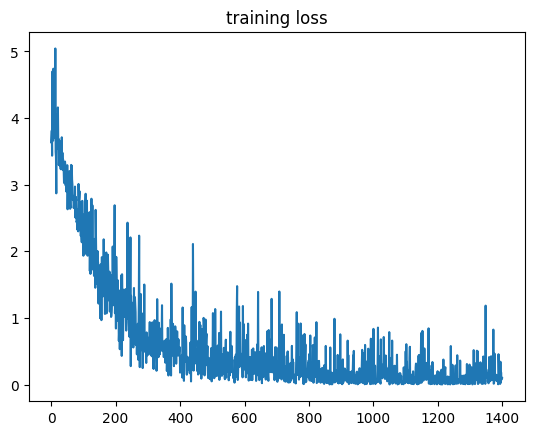

In [27]:
log_interval = 5
n_epoch = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [33]:
def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)

    # Add the batch dimension
    tensor = tensor.unsqueeze(0)  # shape: [1, 1, 8160]

    # Expand the single channel to two channels without duplication of data
    tensor = tensor.expand(1, 2, -1)  # shape: [1, 2, 8160]

    tensor = model(tensor)
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

waveform, sample_rate, utterance, *_ = train_set[-20]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [34]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #18. Expected: cat. Predicted: off.


In [43]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: learn.
